In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import torch 
import torch.nn as nn
import os
import json
import math

from models import simpleLSTM
from utils import run_closed_loop, perf_measure

import matplotlib.dates as mdates
import matplotlib.pyplot as plt

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


myFmt_year = mdates.DateFormatter('%Y-%m-%d')
myFmt_month_day_time = mdates.DateFormatter('%m-%d-%H:%M')
myFmt_month_day = mdates.DateFormatter('%m-%d')
myFmt = mdates.DateFormatter('%H:%M')

### Iniztialize and load already trained model

In [11]:
experiment_path = "./saved_runs/model_with_all_features"
model_name = "best_valid_model.pt"
model_path = os.path.join(experiment_path, model_name)

use_positional_encoding = 'all'
model = simpleLSTM(n_input_features=4, num_layers=4)
model.load_state_dict(torch.load(model_path,map_location=torch.device("cpu")))

<All keys matched successfully>

### Plot Train and Validation Loss curve, learning rate schedule

In [12]:
history_path = os.path.join(experiment_path, 'train_history.csv')
df_train_history = pd.read_csv(history_path, index_col=0)

fig = px.line(df_train_history, x = 'epoch', y = ['train_loss', 'valid_loss'])
fig.show()

fig = px.line(df_train_history, x = 'epoch', y = ['learning_rate'])
fig.show()

### Scaled testset data for one split (month)


In [13]:
# Read test data
experiment_path = "./saved_runs/model_with_all_features"
df_test_scaled_list = []
for i in range(6):
    test_data_path = os.path.join(experiment_path, f'test{i}_data_scaled.csv')
    df_test_scaled = pd.read_csv(test_data_path, index_col = 0)
    # Convert timestamps to datetime objects 
    datetime_index = pd.to_datetime(df_test_scaled.index)
    df_test_scaled.index = datetime_index
    df_test_scaled_list.append(df_test_scaled)

fig = px.line(df_test_scaled_list[0], x = df_test_scaled.index, y =  df_test_scaled.columns)
fig.show()

df_test_scaled.head()

,active_power,sun_altitude,sun_azimuth,irradiance_real,irradiance_fc
_time,,,,,
2021-12-16 00:00:00+00:00,0.742399,0.012836,0.928742,0.0,0.0
2021-12-16 00:15:00+00:00,0.764149,0.005641,0.949502,0.0,0.0
2021-12-16 00:30:00+00:00,0.783176,0.000888,0.971321,0.0,0.0
2021-12-16 00:45:00+00:00,0.783190,-0.001236,0.993796,0.0,0.0
2021-12-16 01:00:00+00:00,0.785272,-0.000640,0.016196,0.0,0.0


### Analyze the predictions
In this section we analyze, the performance of the trained demand forecasting algorithm and its effectiveness according to the detection of hurting band linmits. \
We face the scenario of having acces to all historic data. The power $p$, suns altitude $\phi$,  suns azimuth $\theta$, and the original irradiance $\zeta$. \
We have to define the lookback window for initializing the LSTM. This can be either 1hour, 1day, or 2days of the past measurements. For forecasting we use the available forecasts of the irradiance $\zeta_{fc}$. 

In our setting we initialize the LSTM with past data of one day and forecast for the next 24hours. 
The forecasts are used to extract the timepoint and the strenght of the band hurting.

In [14]:
# Read scalings
scaling_data_path = os.path.join(experiment_path,'scalings.json')
with open(scaling_data_path, 'r') as file:
    scaling_dict = json.load(file)

# prepare sclaings to rescale original power profile:
max_power = scaling_dict['active_power']['max']
min_power = scaling_dict['active_power']['min']

max_irradiance = scaling_dict['irradiance_real']['max']
min_irradiance = scaling_dict['irradiance_real']['min']

max_irradiance_fc = scaling_dict['irradiance_fc']['max']
min_irradiance_fc = scaling_dict['irradiance_fc']['min']


months = ['july', 'august', 'september', 'october', 'november', 'december']
tp_list = []
tn_list = []
fp_list = []
fn_list = []

violation_labels_list = []
violation_predictions_list = []
area_of_harm_labels_list = []
area_of_harm_predictions_list = []
time_of_harm_labels_list = []
time_of_harm_predictions_list = []


for k, month in enumerate(months):
    lookback = 96
    predict_forward = 96
    feed_in_limit = -200
    power_treshold = -200 # -159

    violation_labels = []
    violation_predictions = []

    area_of_harm_prediction = []
    area_of_harm_targets = []

    time_of_harm_prediction = []
    time_of_harm_targets = []

    max_harm_prediction = []
    max_harm_targets = []

    df_test_scaled = df_test_scaled_list[k]
    # Convert timestamps to datetime objects 
    datetime_index = pd.to_datetime(df_test_scaled.index)
    df_test_scaled.index = datetime_index
    # Extract unique days
    unique_days_test = pd.Series(datetime_index).dt.date.unique()

    for i in range(len(unique_days_test)-1):
        df_two_days = df_test_scaled.loc[str(unique_days_test[i]): str(unique_days_test[i+1])]
        predictions = run_closed_loop(model, df_two_days.values, lookback=lookback, future_prediction=predict_forward, use_positional_encoding = use_positional_encoding )
        df_new = pd.DataFrame(columns = ['target', 'prediction', 'delta'])
        df_new['target'] = df_two_days.values[:,0]
        #df_new['index'] = df_new.index
        df_new["irradiance_real"] = df_two_days["irradiance_real"].values
        df_new["irradiance_fc"] = df_two_days["irradiance_fc"].values
        
        df_new.loc[lookback+1:predict_forward+lookback-1, 'prediction'] = predictions
        df_new['prediction'] = df_new['prediction'].fillna(0)
        df_new['target_original'] = df_new['target'] * (max_power - min_power) + min_power # (df_train_val[column] - min_val) / (max_val - min_val)
        df_new['prediction_original'] = df_new['prediction'] * (max_power - min_power) + min_power 
        df_new['irradiance_real_original'] = df_new['irradiance_real'] * (max_irradiance - min_irradiance) + min_irradiance 
        df_new['irradiance_fc_original'] = df_new['irradiance_fc'] * (max_irradiance_fc - min_irradiance_fc) + min_irradiance_fc 

        df_new.index = df_two_days.index

        df_second_day = df_new.iloc[lookback+1::].copy()

        violations_targets_index = df_second_day['target_original'] <= feed_in_limit
        violations_predictions_index = df_second_day['prediction_original'] <= power_treshold # 159 # False negatives verringern, area ofs harms relative klein und zeit kurz, deswegen eher kurz deswegen setzt man das limit runter um sensible anszuschlagen, wenn wir keine Fn haben wollen dannn könnten wir die schwelle runter stellen dann würde es nur zusätzliche 6 

        violation_targets_time = np.sum(violations_targets_index)* 15
        violation_predictions_time = np.sum(violations_predictions_index)* 15
        time_of_harm_targets.append(violation_targets_time)
        time_of_harm_prediction.append(violation_predictions_time)

        violation_targets_sum = np.sum(np.abs(df_second_day[violations_targets_index]['target_original'].values + 200))* 15/60
        violation_predictions_sum = np.sum(np.abs(df_second_day[violations_predictions_index]['prediction_original'].values + 200)) *15/60
        area_of_harm_prediction.append(violation_predictions_sum)
        area_of_harm_targets.append(violation_targets_sum)

        #fig, ax = plt.subplots()
        #ax.plot(df_second_day['target_original'], label = 'target')
        #ax.plot(df_second_day['prediction_original'], label = 'prediction')
        #ax.legend()

        #plt.show()

        max_harm_prediction.append((df_second_day['prediction_original']).min())
        max_harm_targets.append((df_second_day['target_original'].min()))
        #print(violation_targets_values,  'kWh')
        #print(violation_predictions_values, 'kWh')

        #df_new['']
        #print(violations_targets_index)
        #print(violations_predictions_index)

        if (violations_targets_index).any():
            violation_labels.append(1)
        else:
            violation_labels.append(0)

        if (violations_predictions_index).any():
            violation_predictions.append(1)
        else:
            violation_predictions.append(0)
    
    
    #conv_matrix = confusion_matrix(violation_labels, violation_predictions).ravel()
    #print(conv_matrix)
    #tn, fp, fn, tp = conv_matrix.ravel()
    
    (tp, tn, fp, fn) = perf_measure(np.array(violation_labels), np.array(violation_predictions))

    tp_list.append(tp)
    tn_list.append(tn)
    fp_list.append(fp)
    fn_list.append(fn)

    violation_labels_list.append(violation_labels)
    violation_predictions_list.append(violation_predictions)

    area_of_harm_labels_list.append(area_of_harm_targets)
    area_of_harm_predictions_list.append(area_of_harm_prediction)
    time_of_harm_labels_list.append(time_of_harm_targets)
    time_of_harm_predictions_list.append(time_of_harm_prediction)


    print('Month:', month)
    print(f'Number of test days: {len(violation_labels)}')
    print('labels:      ', violation_labels)
    print('prediction:  ', violation_predictions)
    print('area of harm labels[kWh]:      ', area_of_harm_targets)
    print('area of harm prediction[kWh]:  ', area_of_harm_prediction)

    print('max harm labels[kW]:      ', max_harm_targets)
    print('max harm prediction[kW]:  ', max_harm_prediction)

    print('time of harm labels[minutes]:      ', time_of_harm_targets)
    print('time of harm prediction[minutes]:  ', time_of_harm_prediction)

    abs_harm_difference = np.abs(np.array(max_harm_prediction)-np.array(max_harm_targets))
    #print('difference:', abs_harm_difference)
    #print('average_difference:', np.mean(abs_harm_difference))
df_confusion = pd.DataFrame({'month' : months, 'TP' : tp_list,  'TN' : tn_list, 'FP' : fp_list, 'FN' : fn_list})


Month: july
Number of test days: 14
labels:       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
prediction:   [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
area of harm labels[kWh]:       [26.477074341810486, 55.00662540872451, 81.61782793409385, 29.543247439032793, 95.20481715399261, 70.72374854800258, 27.78868786412303, 31.61025830769685, 15.487057040365492, 16.922721556645314, 18.534735824739506, 15.008360863511335, 5.875761566573502, 5.009707040870333]
area of harm prediction[kWh]:   [0.0, 70.7685288304853, 87.72760790179768, 39.84652709208262, 76.35416488472896, 85.27400611358412, 80.22741787667705, 0.2902532542995857, 22.7954364845909, 35.01880168858603, 52.22671201682614, 96.34701435423236, 48.62508246530597, 0.0]
max harm labels[kW]:       [-238.97233752548016, -230.00932342828048, -231.57110554379148, -224.96314593132416, -246.9089584784967, -242.0551310366572, -231.88431259729003, -225.51154387335143, -214.6139046698168, -210.1102595040054, -212.11062924135592, -218.71492601716767,

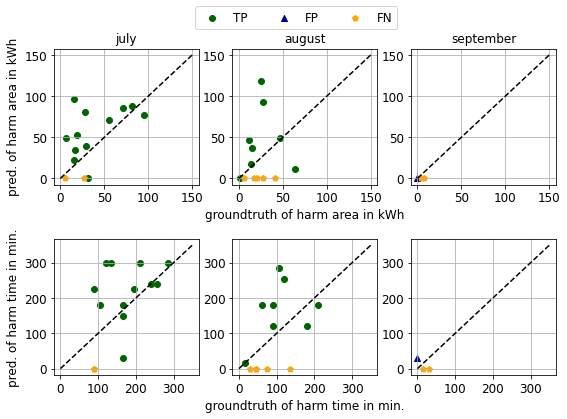

In [15]:
months = ['july', 'august', 'september']

fig, axs = plt.subplots(2,3, figsize= (3*3, 2*3))

for i in range(len(months)):
    month = months[i]
    violation_labels = np.array(violation_labels_list[i])
    violation_predictions = np.array(violation_predictions_list[i])

    area_of_harm_labels = np.array(area_of_harm_labels_list[i])
    area_of_harm_predictions = np.array(area_of_harm_predictions_list[i])

    time_of_harm_labels = np.array(time_of_harm_labels_list[i])
    time_of_harm_predictions = np.array(time_of_harm_predictions_list[i])


    y_actual = violation_labels
    y_pred = violation_predictions
    tp_idx = (y_actual==1) & (y_pred==1)
    #tn = np.sum((y_actual==0) & (y_pred==0))
    fp_idx = (y_actual==0) & (y_pred==1)
    fn_idx = (y_actual==1) & (y_pred==0)

    
    axs[0, i].scatter(area_of_harm_labels[tp_idx], area_of_harm_predictions[tp_idx], label= 'TP', color = 'darkgreen', )
    axs[1, i].scatter(time_of_harm_labels[tp_idx], time_of_harm_predictions[tp_idx], label = 'TP', color = 'darkgreen')

    axs[0, i].scatter(area_of_harm_labels[fp_idx], area_of_harm_predictions[fp_idx], label= 'FP', color = 'darkblue', marker = '^')
    axs[1, i].scatter(time_of_harm_labels[fp_idx], time_of_harm_predictions[fp_idx], label = 'FP', color = 'darkblue', marker = '^')

    axs[0, i].scatter(area_of_harm_labels[fn_idx], area_of_harm_predictions[fn_idx], label= 'FN', color = 'orange', marker = 'p')
    axs[1, i].scatter(time_of_harm_labels[fn_idx], time_of_harm_predictions[fn_idx], label = 'FN', color = 'orange', marker ='p' )
    #axs[0, i].legend()
    #axs[1, i].legend()
    
    if i == 100:
        axs[1, i].plot([0, 40], [0, 40], color = 'black', linestyle='dashed')
        axs[0, i].plot([0, 10], [0, 10], color = 'black', linestyle='dashed')
    else:
        axs[1, i].plot([0, 350], [0, 350], color = 'black', linestyle='dashed')
        axs[0, i].plot([0, 150], [0, 150], color = 'black', linestyle='dashed')

    axs[0, i].grid()
    axs[1, i].grid()

    axs[0,i].set_title(month)

axs[0,1].set_xlabel('groundtruth of harm area in kWh')
axs[1,1].set_xlabel('groundtruth of harm time in min.')

axs[0,0].set_ylabel('pred. of harm area in kWh')
axs[1,0].set_ylabel('pred. of harm time in min.')


plt.subplots_adjust(hspace = 0.4, wspace = 0.23)
axs[0, 1].legend(loc='lower left', bbox_to_anchor=(-0.3,1.1), ncol=3)

plt.savefig("./paper_figures/area_time_of_harm.pdf", bbox_inches='tight')



In [16]:
df_confusion['acc'] = (df_confusion['TP'] + df_confusion['TN']) / (df_confusion['TP'] + df_confusion['TN'] + df_confusion['FP'] + df_confusion['FN'])
df_confusion['precision'] = (df_confusion['TP']) / (df_confusion['TP']+ df_confusion['FP'])
df_confusion['recall'] = (df_confusion['TP']) / (df_confusion['TP']+ df_confusion['FN'])
df_confusion['f1'] = 2 *  df_confusion['precision']*df_confusion['recall']/(df_confusion['precision']+df_confusion['recall'])

df_confusion
#print(df_confusion[['month', 'TP', 'TN', 'FP','FN', 'acc', 'f1']].to_latex(index = False, header= True, float_format="{:.2f}".format))

,month,TP,TN,FP,FN,acc,precision,recall,f1
0,july,12,0,0,2,0.857143,1.0,0.857143,0.923077
1,august,8,1,0,5,0.642857,1.0,0.615385,0.761905
2,september,0,11,1,2,0.785714,0.0,0.000000,NaN
3,october,0,14,0,0,1.000000,NaN,NaN,NaN
4,november,0,14,0,0,1.000000,NaN,NaN,NaN
5,december,0,14,0,0,1.000000,NaN,NaN,NaN


### Comparison and Analysis of Model train with different input features

In [17]:
# Read Validation Data
experiment_path = "./saved_runs/model_with_all_features"
valid_active_power_list = []
for i in range(6):
    valid_data_path = os.path.join(experiment_path, f'test{i}_data_scaled.csv')
    df_valid_scaled = pd.read_csv(valid_data_path, index_col = 0)
    # Convert timestamps to datetime objects 
    datetime_index = pd.to_datetime(df_valid_scaled.index)
    df_valid_scaled.index = datetime_index
    unique_days = pd.Series(datetime_index).dt.date.unique()
    for k in range(len(unique_days)):
        valid_active_power = df_valid_scaled.loc[str(unique_days[k])]['active_power'].values.reshape(1,-1)
        if k ==0:
            valid_active_power_set = valid_active_power
        else:
            valid_active_power_set = np.concatenate((valid_active_power_set, valid_active_power), axis = 0)
    #print(valid_active_power_set.shape)
    valid_active_power_list.append(valid_active_power_set)
    
time_of_one_day = pd.Series(df_valid_scaled.loc[str(unique_days[i+1])].index)
valid_active_power_all = np.array(valid_active_power_list).reshape(-1, 96)
print('all validation day-profiles:', valid_active_power_all.shape)


all validation day-profiles: (90, 96)


In [18]:
experiment_path_list = ["./saved_runs/model_with_no_features", "./saved_runs/model_with_sun_features", "./saved_runs/model_with_all_features", "./saved_runs/model_with_all_features"]
positional_encoding_list = ['none', 'sun', 'all', 'all_original']
input_features_list = [1, 3, 4, 4]

model_predictions = []

for experiment_path,  positional_encoding, n_input_features in zip(experiment_path_list, positional_encoding_list, input_features_list):

    #print('')
    model_name = "best_valid_model.pt"
    model_path = os.path.join(experiment_path, model_name)
    history_path = os.path.join(experiment_path, 'train_history.csv')
    df_train_history = pd.read_csv(history_path, index_col=0)

    print(experiment_path, 'min. train loss:', np.min(df_train_history['train_loss'].values), 'min. val loss:', np.min(df_train_history['valid_loss'].values)  )
    use_positional_encoding = positional_encoding
    model = simpleLSTM(n_input_features=n_input_features, num_layers=4)
    model.load_state_dict(torch.load(model_path,map_location=torch.device("cuda:0")))

    lookback = 96
    predict_forward = 96
    predictions_testset_list = []
    for k, df_test_scaled in enumerate(df_test_scaled_list):
        datetime_index = pd.to_datetime(df_test_scaled.index)
        unique_days_test = pd.Series(datetime_index).dt.date.unique()
        for i in range(len(unique_days_test)-2):
            df_two_days = df_test_scaled.loc[str(unique_days_test[i]): str(unique_days_test[i+1])]
            #print(df_two_days.shape)
            predictions = run_closed_loop(model, df_two_days.values, lookback=lookback, future_prediction=predict_forward, use_positional_encoding = use_positional_encoding)
            predictions = predictions.reshape(1,-1)
            if  i==0: 
                predictions_set = predictions
            else:
                predictions_set = np.concatenate((predictions_set, predictions), axis = 0)
        predictions_testset_list.append(predictions_set)
        #print(predictions_set.shape)

    model_predictions.append(predictions_testset_list)

./saved_runs/model_with_no_features min. train loss: 0.002276681515183161 min. val loss: 0.001767960533266887
./saved_runs/model_with_sun_features min. train loss: 0.0022507238577757684 min. val loss: 0.0016550224015954881
./saved_runs/model_with_all_features min. train loss: 0.0009822497342421269 min. val loss: 0.0006714023998938501
./saved_runs/model_with_all_features min. train loss: 0.0009822497342421269 min. val loss: 0.0006714023998938501


none
sun
all


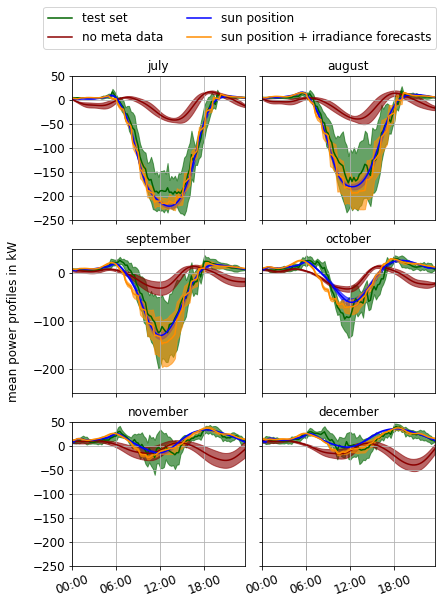

In [22]:
# Plot for comparing the model predictions on the test set with the different scenarion compared to the validation mean power profile
fig, axs = plt.subplots(3,2,  figsize = (6.5,5*2))

colors = ['darkred', 'blue', 'darkorange']
#colors = ['darkorange', 'darkred','blue']
months = ['july', 'august', 'september', 'october', 'november', 'december']
labels = ['no meta data', 'sun position', 'sun position + irradiance forecasts']

for i, (ax, valid_active_power) in enumerate(zip(axs.reshape(-1), valid_active_power_list)):
    valid_active_power = valid_active_power* (max_power - min_power) + min_power #Rescale validation power 

    mean_active_power_valid = np.mean(valid_active_power, axis = 0)
    std_active_power_valid = np.std(valid_active_power, axis = 0)

    #ax.set_ylim([0.05, 0.85])
    ax.set_ylim([-250, 50])
    ax.plot(time_of_one_day[0:-1], mean_active_power_valid[0:-1], label = 'test set', color = 'darkgreen')
    ax.fill_between(time_of_one_day[0:-1], mean_active_power_valid[0:-1]-std_active_power_valid[0:-1], mean_active_power_valid[0:-1]+std_active_power_valid[0:-1],  alpha=0.6, color = 'darkgreen')

for i, (encoding, prediction, color) in enumerate(zip(positional_encoding_list, model_predictions, colors)):
    print(encoding)
    label = labels[i]
    for j, (ax,pred) in enumerate(zip(axs.reshape(-1),prediction)):
        #print(pred.shape)
        pred = pred * (max_power - min_power) + min_power #Rescale to orignal values
        mean_active_power_test = np.mean(pred, axis = 0)
        std_active_power_test = np.std(pred, axis = 0)
        ax.fill_between(time_of_one_day[0:-1], mean_active_power_test-std_active_power_test, mean_active_power_test+std_active_power_test,  alpha=0.6, color = color) #color = 'darkgreen'
        ax.plot(time_of_one_day[0:-1],mean_active_power_test, label =label, color = color)

axs[0,0].legend(loc='lower left', bbox_to_anchor=(-0.2, 1.15), ncol=2)
axs[1,0].set_ylabel('mean power profiles in kW')
axs[1,0].yaxis.set_label_coords(-.3, 0.5)

axs[0,1].set_yticklabels([])
#axs[0,2].set_yticklabels([])
axs[1,1].set_yticklabels([])
#axs[1,2].set_yticklabels([])
axs[2,1].set_yticklabels([])


for i, ax in enumerate(axs.reshape(-1)):
    ax.grid()
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
    ax.xaxis.set_major_formatter(myFmt)
    ax.set_title(months[i])
    ax.set_xlim([time_of_one_day.values[0], time_of_one_day.values[-2]])
    plt.gcf().autofmt_xdate(rotation = 20, ha='center')

plt.subplots_adjust(wspace = 0.1)
plt.savefig("./paper_figures/testset_vs_forecasts_monthly_basis.pdf", bbox_inches='tight')


### Midterm-forcasting comparison 
Between irradiance forecasts and (imaginary result of having the original irradiance)

RMSE with irradiance original: 10.96123325044183
RMSE with irradiance fc: 21.595762504647343
MAE with irradiance original: 6.889362273881509
MAE with irradiance fc: 12.413604909724793
RMSE with irradiance original: 13.417297750337303
RMSE with irradiance fc: 33.6946067027966
MAE with irradiance original: 8.55765757069984
MAE with irradiance fc: 18.784667330263606
RMSE with irradiance original: 20.6581503855338
RMSE with irradiance fc: 30.92087421915513
MAE with irradiance original: 13.91979131009952
MAE with irradiance fc: 18.736079773260155
RMSE with irradiance original: 19.141813405664028
RMSE with irradiance fc: 19.587521043060942
MAE with irradiance original: 13.480821641971138
MAE with irradiance fc: 13.708819172808916
RMSE with irradiance original: 16.54231734777097
RMSE with irradiance fc: 16.87954592888867
MAE with irradiance original: 11.167922304946051
MAE with irradiance fc: 11.472901524992317
RMSE with irradiance original: 13.344790954649003
RMSE with irradiance fc: 13.5134

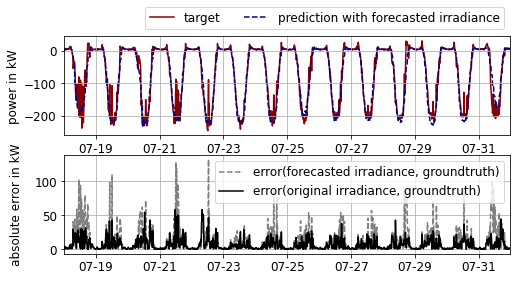

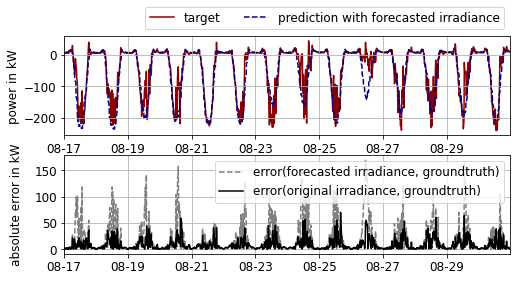

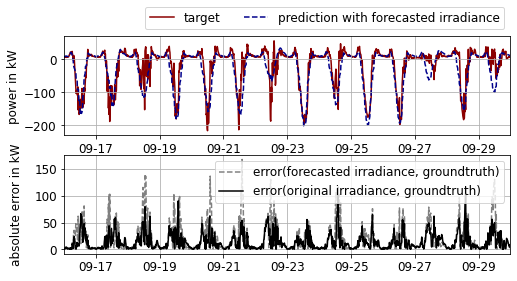

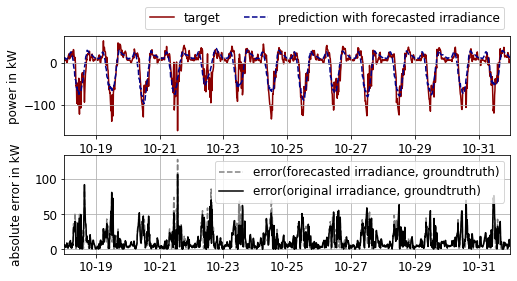

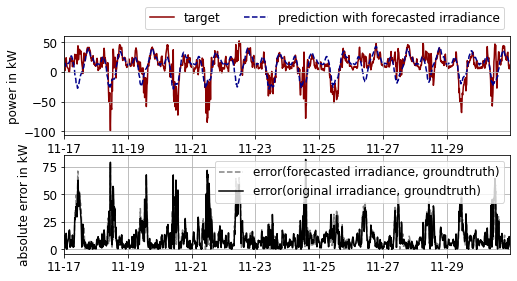

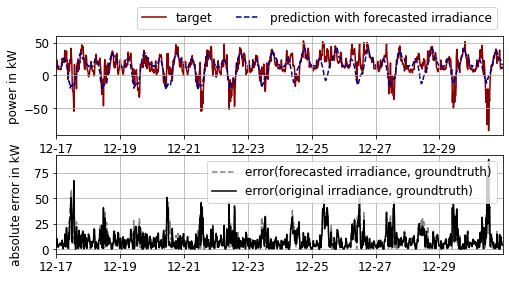

In [23]:
months = ['july', 'august', 'september', 'october', 'november', 'december']

MAE_list_original_irradiance = []
RMSE_list_original_irradiance = []

MAE_list_forecast_irradiance = []
RMSE_list_forecast_irradiance  = []

for i in range(6):
    lookback = 96
    test_values = df_test_scaled_list[i].values
    num_test_samples = test_values.shape[0]
    steps2predict = num_test_samples-lookback

    groundtruth = test_values[lookback+1::, 0] # There is a + 1 shift in the inference loop
    #groundtruth = test_values[lookback:-1, 0] 
    time = pd.Series(df_test_scaled_list[i].index)[lookback:-1]
    predictions_with_irradiance_fc = run_closed_loop(model, test_values, lookback=lookback, future_prediction=steps2predict, use_positional_encoding='all')
    predictions_with_irradiance_original = run_closed_loop(model, test_values, lookback=lookback, future_prediction=steps2predict, use_positional_encoding='all_original')


    groundtruth = groundtruth * (max_power - min_power) + min_power #Rescale to orignal values
    predictions_with_irradiance_fc = predictions_with_irradiance_fc * (max_power - min_power) + min_power #Rescale to orignal values
    predictions_with_irradiance_original = predictions_with_irradiance_original * (max_power - min_power) + min_power #Rescale to orignal values

    fig, ax = plt.subplots(2,1, figsize=(8, 4))

    visualization_idx_start = 0
    visualization_idx_stop = visualization_idx_start + 96*14

    #print(visualization_idx_stop)
    #print(predictions_with_irradiance_fc.shape)

    ax[0].plot(time[visualization_idx_start:visualization_idx_stop], groundtruth[visualization_idx_start:visualization_idx_stop], label = 'target', color = 'darkred', zorder = 0)
    ax[0].plot(time[visualization_idx_start:visualization_idx_stop], predictions_with_irradiance_fc[visualization_idx_start:visualization_idx_stop], label = 'prediction with forecasted irradiance',linestyle = '--', color = 'darkblue', zorder = 1)

    ax[0].set_ylabel('power in kW')
    ax[0].legend()
    ax[0].grid()
    ax[0].xaxis.set_major_formatter(myFmt_month_day)
    ax[0].set_xlim([time[visualization_idx_start:visualization_idx_stop].values[0], time[visualization_idx_start:visualization_idx_stop].values[-1]])

    ax[0].legend(loc='lower right', bbox_to_anchor=(1, 1.01), ncol=2)

    squared_error_forecast = (predictions_with_irradiance_fc-groundtruth)**2
    squared_error_original = (predictions_with_irradiance_original-groundtruth)**2
    absolute_error_forecast = np.abs(groundtruth - predictions_with_irradiance_fc)
    absolute_error_original = np.abs(groundtruth - predictions_with_irradiance_original)

    absolute_percentage_eror_forecast = np.abs((groundtruth - predictions_with_irradiance_fc)/groundtruth)
    absolute_percentage_eror_original = np.abs((groundtruth - predictions_with_irradiance_original)/groundtruth)

    ax[1].plot(time[visualization_idx_start:visualization_idx_stop], absolute_error_forecast[visualization_idx_start:visualization_idx_stop], label = 'error(forecasted irradiance, groundtruth)', linestyle = '--', color = 'gray')
    ax[1].plot(time[visualization_idx_start:visualization_idx_stop], absolute_error_original[visualization_idx_start:visualization_idx_stop], label = 'error(original irradiance, groundtruth)', color = 'black')

    #ax[1].plot(time[visualization_idx_start:visualization_idx_stop],  np.ones(len(time[visualization_idx_start:visualization_idx_stop].values)) * squared_error_forecast[visualization_idx_start:visualization_idx_stop].mean(), label = 'MSE', color = 'violet')
    
    
    
    #ax[1].legend()
    ax[1].legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=1)
    ax[1].grid()
    ax[1].set_ylabel('absolute error in kW', labelpad=11)
    ax[1].xaxis.set_major_formatter(myFmt_month_day)
    ax[1].set_xlim([time[visualization_idx_start:visualization_idx_stop].values[0], time[visualization_idx_start:visualization_idx_stop].values[-1]])
    #ax[0].plot(time, groundtruth, label = 'target')

    plt.savefig(f"./paper_figures/mid_term_forecast_{months[i]}.pdf", bbox_inches='tight')
    #tikzplotlib.save(f"./paper_figures/mid_term_forecast_comparison.tex")

    mse_original_irradiance = squared_error_original.mean()
    mse_forecast_irradiance = squared_error_forecast.mean()

    mae_original_irradiance = absolute_error_original.mean()
    mae_forecast_irradiance = absolute_error_forecast.mean()

    rmse_original_irradiance = math.sqrt(mse_original_irradiance)
    #rmse_original_irradiance = mse_original_irradiance
    rmse_forecast_irradiance = math.sqrt(mse_forecast_irradiance)
    #rmse_forecast_irradiance = mse_forecast_irradiance

    print('RMSE with irradiance original:', rmse_original_irradiance) 
    print('RMSE with irradiance fc:', rmse_forecast_irradiance)
    print('MAE with irradiance original:', mae_original_irradiance) 
    print('MAE with irradiance fc:', mae_forecast_irradiance)

    MAE_list_original_irradiance.append(mae_original_irradiance)
    RMSE_list_original_irradiance.append(rmse_original_irradiance)

    MAE_list_forecast_irradiance.append(mae_forecast_irradiance)
    RMSE_list_forecast_irradiance.append(rmse_forecast_irradiance)
    #print(f'MSE increases due to uncertainty of irradiance by: {mse_forecast_irradiance/mse_original_irradiance}')

### RMSE and MAE Analysis on a monthly basis

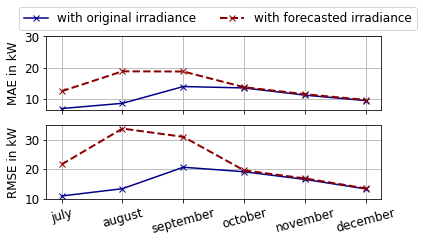

In [25]:
import warnings
warnings.filterwarnings("ignore")
fig, ax = plt.subplots(2,1, figsize=(6, 3))

ax[0].plot(np.arange(6), MAE_list_original_irradiance, label = 'with original irradiance', marker='x', color = 'darkblue')
ax[0].plot(np.arange(6), MAE_list_forecast_irradiance, label = 'with forecasted irradiance', marker='x', linestyle = '--', linewidth=2, color = 'darkred')

ax[0].set_ylabel('MAE in kW')
ax[1].plot(np.arange(1,7), RMSE_list_original_irradiance, label = 'with original irradiance', marker='x',  color = 'darkblue')
ax[1].plot(np.arange(1,7), RMSE_list_forecast_irradiance, label = 'with forecasted irraidance', marker='x', linestyle = '--', linewidth=2, color = 'darkred')
ax[1].set_ylabel('RMSE in kW')

ax[0].set_xticklabels([])
ax[1].set_xticklabels(['dummy', 'july', 'august', 'september', 'october', 'november', 'december'], rotation = 15)

ax[1].set_yticks([10, 20, 30])
#ax[1].set_yticks([0.025, 0.05, 0.075, 0.1])
ax[0].set_yticks([10, 20, 30])

ax[0].legend(loc='lower left', bbox_to_anchor=(-0.1, 1.01), ncol=2)
#ax[1].legend()
ax[0].grid()
ax[1].grid()

plt.savefig("./paper_figures/RMSE_MAE_monthly_basis.pdf", bbox_inches='tight')